In [2]:
# 라이브러리 설치
!pip install -q google-play-scraper transformers torch accelerate sentencepiece konlpy wordcloud tqdm

from google_play_scraper import Sort, reviews
import os, re, math
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 11.5 MB/s eta 0:00:00


In [3]:
# 한글 폰트 설치
!apt-get -qq update
!apt-get -qq install -y fonts-nanum fonts-noto-cjk > /dev/null

# 실제 폰트 파일 경로 탐색
def find_korean_ttf():
    for f in fm.fontManager.ttflist:
        if f.name in {"NanumGothic","Nanum Gothic","Noto Sans CJK KR","Noto Sans CJK"} and os.path.exists(f.fname):
            return f.fname
    # 시스템 경로 서치(백업)
    for root, _, files in os.walk('/usr/share/fonts'):
        for file in files:
            low = file.lower()
            if (low.endswith(('.ttf','.otf'))) and ('nanum' in low or 'noto' in low):
                return os.path.join(root, file)
    # 최후의 보루 - 기본 폰트(한글 일부 깨질 수 있음)
    return fm.findfont('DejaVu Sans')

FONT_PATH = find_korean_ttf()
font_name = fm.FontProperties(fname=FONT_PATH).get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
FONT_PATH

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


'/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [4]:
# 하나원큐 앱 리뷰 크롤링
# 참고: 하나원큐 앱 패키지명은 "com.hanabank.ebk.channel.android.hananbank"
result, _ = reviews(
    'com.hanabank.ebk.channel.android.hananbank',
    lang='ko',             # 한국어 리뷰만
    country='kr',          # 대한민국
    sort=Sort.NEWEST,      # 최신순
    count=10000             # 수집 개수
)

In [24]:
# DataFrame으로 변환
df = pd.DataFrame(result)
df = df[['content', 'score', 'at']]

In [25]:
df.count()

,0
content,10000
score,10000
at,10000


In [29]:
# 멀티링구얼 감성모델 로딩
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

device = 0 if torch.cuda.is_available() else -1
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=device,
    top_k=None,               # 단일 라벨만 받기
    return_all_scores=True    # 1~5 모든 확률도 얻기
)

Device set to use cpu


In [30]:
# 감성 추론 함수(배치 처리 + 레이블/확률 정리)
def predict_sentiment(texts, batch_size=32, max_len=256):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        # 길이 너무 긴 텍스트는 자르기 (성능/메모리 방지)
        batch = [t[:2000] for t in batch]
        out = pipe(batch, truncation=True, max_length=max_len)
        # out: 각 문장별로 [{"label":"1 star","score":..}, ...] 리스트
        for scores in out:
            # 가장 높은 점수의 라벨 선택
            best = max(scores, key=lambda x: x['score'])
            label = best['label']  # "1 star" ~ "5 stars"
            # 1~5 확률 벡터도 보관
            star_probs = {int(s['label'].split()[0]): float(s['score']) for s in scores}
            results.append((label, star_probs))
    return results

preds = predict_sentiment(df['content'].tolist(), batch_size=32)
len(preds), preds[0]

100%|██████████| 313/313 [27:37<00:00,  5.30s/it]


(10000,
 ('5 stars',
  {5: 0.44618549942970276,
   4: 0.4021294414997101,
   3: 0.11631930619478226,
   2: 0.021931687369942665,
   1: 0.013434087857604027}))

In [31]:
# 별점 -> (긍정/부정/중립) 매핑
def label_to_sentiment(label):
    # "1 star", "2 stars", ...
    star = int(label.split()[0])
    if star <= 2:
        return "부정"
    elif star == 3:
        return "중립"
    else:
        return "긍정"

df['star_label'] = [p[0] for p in preds]
df['sentiment'] = df['star_label'].apply(label_to_sentiment)

# 신뢰도(최고 확률)도 같이 보관 (리포트에 도움)
df['confidence'] = [max(p[1].values()) for p in preds]

df[['content','star_label','sentiment','confidence']].head(10)


,content,star_label,sentiment,confidence
0,편리하게 사용잘하고 있습니다,5 stars,긍정,0.446185
1,스렉,4 stars,긍정,0.252629
2,아니 이걸 왜깔래..?,1 star,부정,0.390790
3,이건그냥걸어다니는쑤레기아닌가??,1 star,부정,0.413797
4,아니 비밀번호재등록누르면자꾸 일로보내냐고 홈페이지에서 하게하면되는걸ㅡㅡ또종료라네 미...,1 star,부정,0.468080
5,보통 평범 잘안쓰는것 같음,3 stars,중립,0.435321
6,이거 왜 없애는지 모르겠네...정식버전보다 나은데,2 stars,부정,0.328734
7,친절히 하고 있네요.,5 stars,긍정,0.505128
8,편해요,3 stars,중립,0.260413
9,편리하고 빨라서좋아요,5 stars,긍정,0.524751


In [39]:
!pip install openpyxl

# 크롤링한 리뷰 데이터를 엑셀 파일로 저장한다.
df.to_excel('하나원큐앱 리뷰 데이터.xlsx', index=False, engine='openpyxl')
print("✅ 저장 완료: 하나원큐앱 리뷰 데이터.xlsx")

✅ 저장 완료: 하나원큐앱 리뷰 데이터.xlsx


In [17]:
# Malgun Gothic 설치
!apt-get -qq update
!apt-get -qq install -y fonts-freefont-ttf
!wget -q https://github.com/kyubyong/nlp_tasks/raw/master/fonts/malgun.ttf -O /usr/share/fonts/truetype/malgun.ttf


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-freefont-ttf.
(Reading database ... 126714 files and directories currently installed.)
Preparing to unpack .../fonts-freefont-ttf_20120503-10build1_all.deb ...
Unpacking fonts-freefont-ttf (20120503-10build1) ...
Setting up fonts-freefont-ttf (20120503-10build1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


✅ 적용된 폰트: NanumGothic


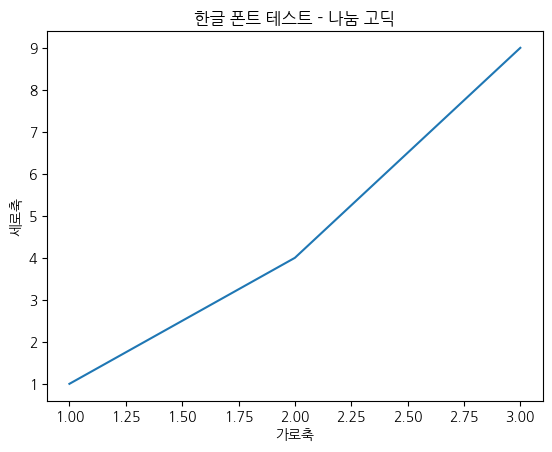

In [32]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
assert os.path.exists(FONT_PATH), "❌ Nanum Gothic 폰트가 설치되지 않았습니다."

# 폰트 등록
fm.fontManager.addfont(FONT_PATH)
font_name = fm.FontProperties(fname=FONT_PATH).get_name()

# Matplotlib 기본 폰트 지정
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

print("✅ 적용된 폰트:", font_name)

# 테스트
plt.title("한글 폰트 테스트 - 나눔 고딕")
plt.plot([1, 2, 3], [1, 4, 9])
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.show()


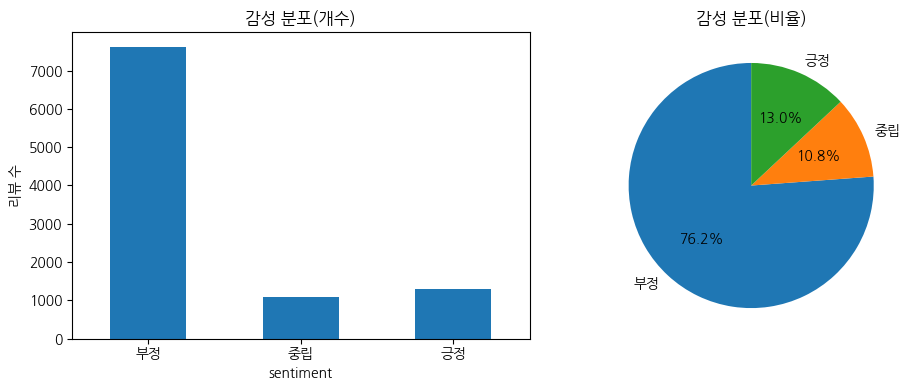

In [33]:
# 시각화
counts = df['sentiment'].value_counts().reindex(['부정','중립','긍정']).fillna(0).astype(int)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
counts.plot(kind='bar')
plt.title('감성 분포(개수)')
plt.xticks(rotation=0)
plt.ylabel('리뷰 수')

plt.subplot(1,2,2)
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('감성 분포(비율)')
plt.ylabel('')

plt.tight_layout()
plt.show()


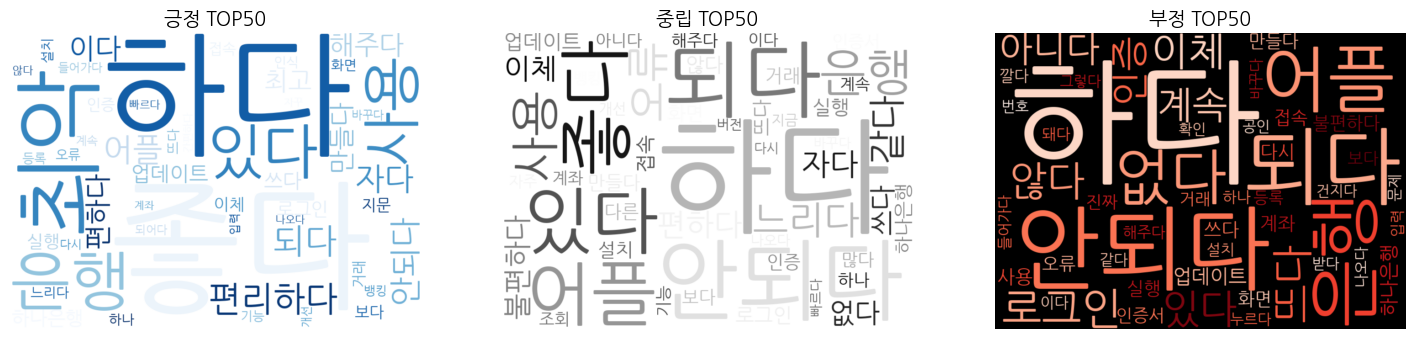

In [35]:
# 토큰화(자동 불용어/품사기반) -> TOP30 키워드 워드클라우드로 시각화
# 품사 기반 불용 처리(명사/형용사/동사만 사용)
from konlpy.tag import Okt
okt = Okt()

def tokenize_keep_keywords(txt):
    tokens = okt.pos(txt, stem=True)  # (단어, 품사)
    # 조사, 어미, 감탄사 등 제거하고 명사/형용사/동사만 남김
    keep = {'Noun','Adjective','Verb'}
    return [w for (w, pos) in tokens if pos in keep and len(w) > 1]

df['tokens'] = df['content'].astype(str).apply(tokenize_keep_keywords)

# 감성별 토큰 모음
pos_tokens = sum(df[df['sentiment']=='긍정']['tokens'], [])
neu_tokens = sum(df[df['sentiment']=='중립']['tokens'], [])
neg_tokens = sum(df[df['sentiment']=='부정']['tokens'], [])

# TOP50 빈도 추출
pos_top50 = dict(Counter(pos_tokens).most_common(50))
neu_top50 = dict(Counter(neu_tokens).most_common(50))
neg_top50 = dict(Counter(neg_tokens).most_common(50))

# 워드클라우드 생성 유틸
def make_wc_from_freq(freq_dict, bg='white', cmap=None):
    # 빈 dict 방어
    if not freq_dict:
        freq_dict = {'데이터':1}
    wc = WordCloud(font_path=FONT_PATH, width=900, height=650,
                   background_color=bg, colormap=cmap)
    return wc.generate_from_frequencies(freq_dict)

wc_pos = make_wc_from_freq(pos_top50, bg='white', cmap='Blues')
wc_neu = make_wc_from_freq(neu_top50, bg='white', cmap='Greys')
wc_neg = make_wc_from_freq(neg_top50, bg='black', cmap='Reds')

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.title('긍정 TOP50', fontsize=14)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('중립 TOP50', fontsize=14)
plt.imshow(wc_neu, interpolation='bilinear')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('부정 TOP50', fontsize=14)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

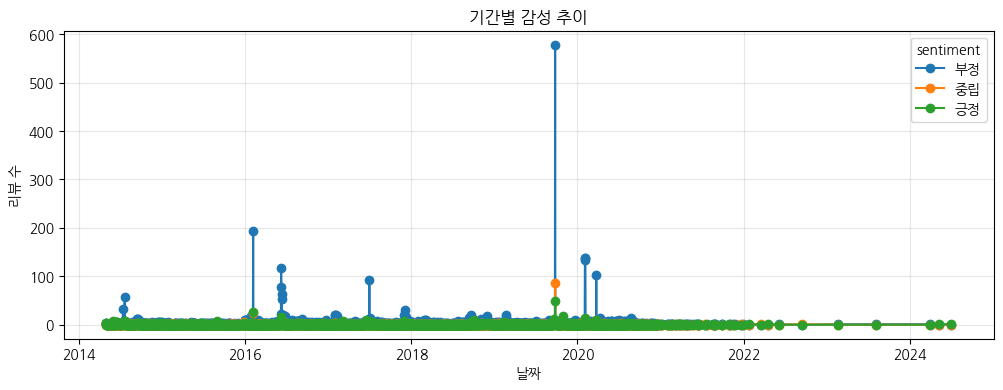

In [36]:
# 기간별 감성 트렌드 예시
if 'at' in df.columns:
    tmp = df.copy()
    tmp['date'] = pd.to_datetime(tmp['at']).dt.date
    trend = tmp.groupby(['date','sentiment']).size().unstack(fill_value=0).reindex(columns=['부정','중립','긍정'])
    trend.plot(figsize=(12,4), marker='o')
    plt.title('기간별 감성 추이')
    plt.ylabel('리뷰 수')
    plt.xlabel('날짜')
    plt.grid(True, alpha=.3)
    plt.show()
